# DSE 220 Final Project

### Load Library

In [1]:
import gzip
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict
from collections import Counter
from statistics import mean 

from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.sentiment.vader import allcap_differential

from sklearn import svm
from sklearn import linear_model

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

## Part 1. Data Process

In [2]:
# Load data functions. 
def readGz(f):
    for l in gzip.open(f):
        yield eval(l)

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [5]:
# Convert to dataframe.
df = getDF('train.json.gz')
test_df = getDF('test_Helpful.json.gz')

### Explotary Data Analysis
#### Data Summary

In [6]:
print("Number of samples:", df.shape[0])
# sample:
df.iloc[0,:]

Number of samples: 200000


categoryID                                                        0
categories        [[Clothing, Shoes & Jewelry, Women], [Clothing...
itemID                                                   I655355328
reviewerID                                               U745881038
rating                                                            3
reviewText        These are cute, but they are a little small.  ...
reviewHash                                               R115160670
reviewTime                                              05 20, 2014
summary                                                        Cute
unixReviewTime                                           1400544000
helpful                                 {'outOf': 0, 'nHelpful': 0}
price                                                           NaN
Name: 0, dtype: object

In [7]:
# Check number of NaN value in each column.
df.isnull().sum()

categoryID             0
categories             0
itemID                 0
reviewerID             0
rating                 0
reviewText             0
reviewHash             0
reviewTime             0
summary                0
unixReviewTime         0
helpful                0
price             125851
dtype: int64

In [8]:
# Append two colums of "outOf" and "nHelpful"
df = df.join(pd.DataFrame(df["helpful"].to_dict()).T)
df = df.drop(['helpful'],axis=1)
df['helpfulrate']=df['nHelpful']/df['outOf']
df['helpfulrate'].fillna(0,inplace=True)

In [9]:
print('Number of reviews with no vote:',df[df['outOf']==0].count()[0])
print('Number of reviews with vote:',df[df['outOf']>0].count()[0])

Number of reviews with no vote: 136984
Number of reviews with vote: 63016


In [10]:
# Remove no voting reviews.
df_voted=df[df['outOf']!=0]
df_voted.shape

(63016, 14)

#### Helfulrate

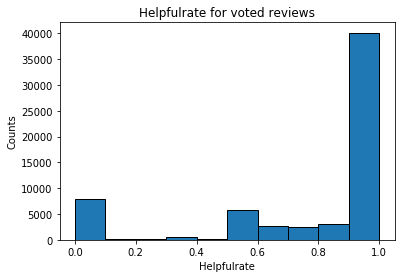

In [11]:
# Voted reviews average helpfulrate.
plt.hist(df_voted['helpfulrate'],10,ec='black')
plt.title('Helpfulrate for voted reviews')
plt.xlabel('Helpfulrate')
plt.ylabel('Counts')
# plt.savefig('helpfulrate_voted_all.jpg')
plt.show()

#### Rating

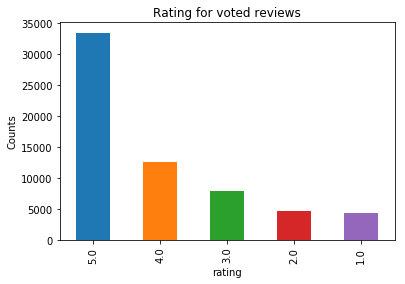

In [12]:
# Voted review counts in each product rating.
df_voted['rating'].value_counts().plot.bar()
plt.title('Rating for voted reviews')
plt.xlabel('rating')
plt.ylabel('Counts')
# plt.savefig('rating_voted_all.pdf')
plt.show()

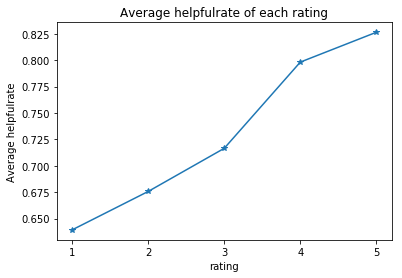

In [13]:
# rating vs avgHelpfulrate
s_1=df_voted.groupby('rating')['helpfulrate'].mean()
plt.plot(s_1.index, s_1, '*-')
plt.xticks(range(1,6))
plt.title('Average helpfulrate of each rating')
plt.xlabel('rating')
plt.ylabel('Average helpfulrate')
# plt.savefig('rating_avgHelpfulrate_voted_all.pdf')
plt.show()

#### Category

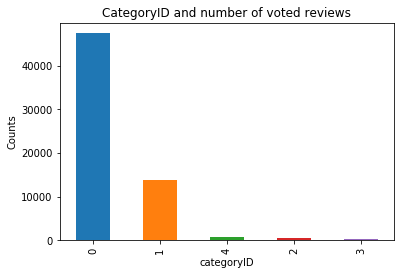

In [14]:
# Voted reviews counts in each categoryID. 
df_voted['categoryID'].value_counts().plot.bar()
plt.title('CategoryID and number of voted reviews')
plt.xlabel('categoryID')
plt.ylabel('Counts')
# plt.savefig('categoryID_voted_all.pdf')
plt.show()

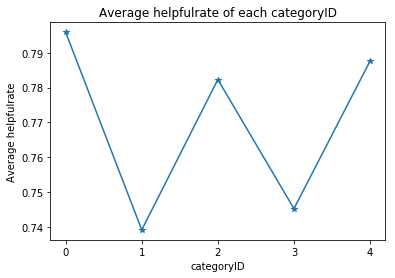

In [15]:
# Category vs avgHelpfulrate
s_2=df_voted.groupby('categoryID')['helpfulrate'].mean()
plt.plot(s_2.index, s_2, '*-')
plt.xticks(range(5))
plt.title('Average helpfulrate of each categoryID')
plt.xlabel('categoryID')
plt.ylabel('Average helpfulrate')
# plt.savefig('categoryID_avgHelpfulrate_voted_all.pdf')
plt.show()

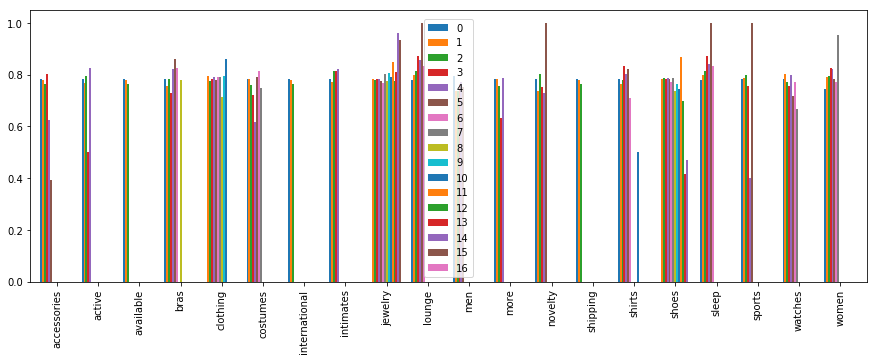

In [16]:
s_cate = df['categories']
categories={}
for i in s_cate.index:    
    categories[i]=[]
    for item in s_cate[i]:
        for w in item:
            categories[i].append(w)

categories=[str(categories[i]) for i in categories.keys()]
# Count category    
vectorizer = CountVectorizer(max_features=20)
cate_count = vectorizer.fit_transform(pd.Series(categories))
category=vectorizer.get_feature_names()
df_category = pd.DataFrame(data=cate_count.toarray(), columns = category)
# df_category
# plot 
df_category['helpfulrate'] = df_voted['helpfulrate']
S={}
for label in df_category.columns[:-1]:
    S[label]=df_category.groupby(label)['helpfulrate'].mean()
DF=pd.DataFrame(S).T
DF.plot.bar(figsize=(15,5),width=0.8)

#### Review Time

In [17]:
## Time 
time=[int(i[-4:]) for i in df_voted['reviewTime']]
df_voted['time']=time
pd.DataFrame({'Year':df_voted.groupby('time')['helpfulrate'].count().index,
             'Count':np.array(df_voted.groupby('time')['helpfulrate'].count()),
             'AvgHelpfulRate':np.array(df_voted.groupby('time')['helpfulrate'].mean())})

,Year,Count,AvgHelpfulRate
0,2003,2,0.952381
1,2004,4,0.942113
2,2005,18,0.846171
3,2006,67,0.865395
4,2007,270,0.842723
5,2008,446,0.849477
6,2009,858,0.846909
7,2010,1607,0.822857
8,2011,4345,0.820282
9,2012,11162,0.800393


#### OutOf (total votes)

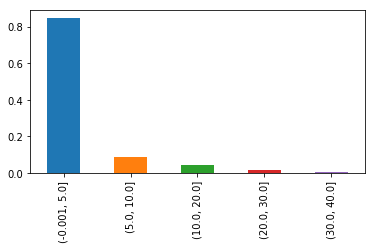

In [18]:
out = pd.cut(df_voted['outOf'], bins=[0,5,10,20,30,40],include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True)
ax = out_norm.plot.bar(figsize=(6,3),)
plt.savefig('outof_voted.jpg')
plt.show()

In [19]:
count=[]
percentage=[]
average=[]
for r in range(5,55,5):
    c= df_voted[(df_voted['outOf']<=r) & (df_voted['outOf']>r-5)]['helpfulrate'].count()
    p = np.round(c/df_voted.shape[0],2)
    m = np.round(df_voted[(df_voted['outOf']<=r) & (df_voted['outOf']>r-5)]['helpfulrate'].mean(),4)
    
    count.append(c)
    percentage.append(p)
    average.append(m)

count.append(df_voted[df_voted['outOf']>50]['helpfulrate'].count())
percentage.append(np.round(df_voted[df_voted['outOf']>50]['helpfulrate'].count()/df_voted.shape[0],4))
average.append(np.round(df_voted[df_voted['outOf']>50]['helpfulrate'].mean(),4))


range_list = [(a,a+5)for a in range(0,50,5)]
max_outof=max(df_voted['outOf'])
range_list.append((50,max_outof))
outOf = pd.DataFrame({'Total_votes_range': range_list,'counts':count,'percentage':percentage,'avgHelpfulrate':average})
outOf

,Total_votes_range,counts,percentage,avgHelpfulrate
0,"(0, 5)",53025,0.8400,0.7652
1,"(5, 10)",5322,0.0800,0.8554
2,"(10, 15)",1854,0.0300,0.8855
3,"(15, 20)",947,0.0200,0.8953
4,"(20, 25)",576,0.0100,0.9054
5,"(25, 30)",326,0.0100,0.9123
6,"(30, 35)",224,0.0000,0.9228
7,"(35, 40)",153,0.0000,0.9128
8,"(40, 45)",106,0.0000,0.9404
9,"(45, 50)",95,0.0000,0.9286


#### Review Length

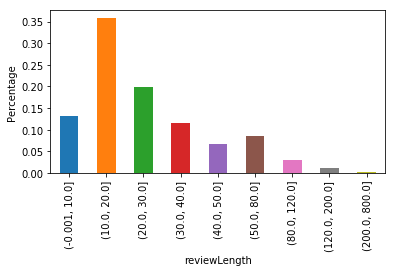

In [20]:
# count word frequency in review text . 
def get_review_length_feature(df):
    
    count=CountVectorizer(stop_words='english')
    count.fit(df['reviewText'])
    review_count=count.transform(df['reviewText'])
    review_length = np.count_nonzero(review_count.toarray(),axis=1)
    
    return review_length
review_length=get_review_length_feature(df_voted)
df_voted['reviewLength']=review_length

# Plot
out = pd.cut(df_voted['reviewLength'], bins=[0, 10, 20, 30, 40, 50, 80, 120, 200,800],include_lowest=True)
out_norm = out.value_counts(sort=False, normalize=True)
ax = out_norm.plot.bar(figsize=(6,3))
plt.xlabel('reviewLength')
plt.ylabel('Percentage')
plt.show()

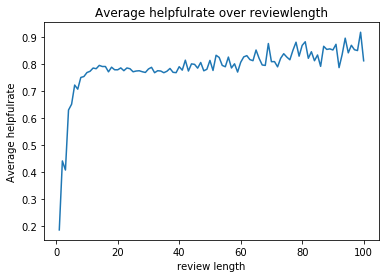

In [21]:
length_rate = df_voted[df_voted['reviewLength']<=100].groupby('reviewLength')['helpfulrate'].mean()
plt.plot(length_rate)
plt.title('Average helpfulrate over reviewlength')
plt.xlabel('review length')
plt.ylabel('Average helpfulrate')
# plt.savefig('reviewlength_avgHelpfulrate_voted_all.pdf')
plt.show()

## Part 2. Modeling & Tuning

### train validation split (0.4)

In [22]:
train_val=list(readGz("train.json.gz"))
test=list(readGz("test_Helpful.json.gz"))
train,valid = train_test_split(train_val,test_size=0.4,random_state=10)

In [23]:
print('Training data size:',len(train))
print('Validation data size:',len(valid))
print('Test data size:',len(test))

Training data size: 120000
Validation data size: 80000
Test data size: 14000


### Function for feature selection

In [24]:
# Get item average rating.
def get_average_rating(data):
    
    allRating=[]
    itemRating=defaultdict(list)
    userRating=defaultdict(list)

    for l in data:
        user,item,rating=l['reviewerID'],l['itemID'],l['rating']
        allRating.append(rating)
        itemRating[item].append(rating)
        userRating[user].append(rating)
       
    itemAvgRating = {} 
    for item in itemRating:
        itemAvgRating[item] = sum(itemRating[item])/len(itemRating[item])
        
    userAvgRating = {} 
    for user in userRating:
        userAvgRating[user] = sum(userRating[user])/len(userRating[user])
       
  
    avgRating = mean(allRating)
    
    return itemAvgRating,userAvgRating,avgRating

In [25]:
# Get user average helpfulrate.
def get_average_helpfulrate(data):
    allHelpful = []
    userHelpful=defaultdict(list)
    itemHelpful=defaultdict(list)
    for l in data:
        item,user=l['itemID'],l['reviewerID']
        userHelpful[user].append(l['helpful'])
        itemHelpful[item].append(l['helpful'])
        allHelpful.append(l['helpful'])
        
    # userAvgHelpfulRate
    userAvgHelpfulRate = {}
    for user in userHelpful:
        totalOutOf_user = sum([x['outOf'] for x in userHelpful[user]])
        if totalOutOf_user >0:
            userAvgHelpfulRate[user] = sum([x['nHelpful'] for x in userHelpful[user]]) * 1.0 / totalOutOf_user
        else:
            userAvgHelpfulRate[user] = 0
    # itemAvgHelpfulRate 
    itemAvgHelpfulRate = {}        
    for item in itemHelpful:
        totalOutOf_item = sum([x['outOf'] for x in itemHelpful[item]])
        if totalOutOf_item >0:
            itemAvgHelpfulRate[item] = sum([x['nHelpful'] for x in itemHelpful[item]]) * 1.0 / totalOutOf_item
        else:
            itemAvgHelpfulRate[item] = 0
             
    avgHelpfulRate = sum([x['nHelpful'] for x in allHelpful]) * 1.0 / sum([x['outOf'] for x in allHelpful])
    
    return userAvgHelpfulRate, itemAvgHelpfulRate, avgHelpfulRate

In [26]:
# Minmun and maximum review time.
def get_time_range(data):
    time=[]
    for l in data:
        time.append(int(l['reviewTime'][-4:]))
       
    return min(time), max(time)

In [27]:
# Get review length. 
def reviewCounts(data):  
    user_item_WordCounts={}
    user_item_SentenceCounts={}
    user_item_CharacterCounts={}
    user_item_Exclamations={}
    user_item_Allcaps={}
    
    for l in data:
        user,item,review = l['reviewerID'],l['itemID'],l['reviewText']
        words = review.split()
        user_item_WordCounts[user,item]=len(words)
        user_item_SentenceCounts[user,item]=len(review.split("."))
        user_item_CharacterCounts[user,item]=len(review)
        user_item_Exclamations[user,item]=len([w for w in words if w == '!'])
        user_item_Allcaps[user,item]=allcap_differential(words)

    return user_item_WordCounts, user_item_SentenceCounts,\
           user_item_CharacterCounts, user_item_Exclamations,user_item_Allcaps


In [28]:
# Get helpful review text average counts.(words, sentences, allCaps, Exclamations)
def get_helpful_review_average_counts(data,min_outof):
    allWordCounts=[]
    allSentenceCounts=[]
    allCharacterCounts=[]
    allExclamationCounts=[]
    for l in data:
        user,item,review = l['reviewerID'],l['itemID'],l['reviewText']
        if l['helpful']['outOf']>min_outof:
            review=l['reviewText']
            words = review.split()
            allWordCounts.append(len(words))
            allSentenceCounts.append(len(review.split(".")))
            allCharacterCounts.append(len(review))
            allExclamationCounts.append(len([w for w in words if w == '!']))
            
    avgWordCounts= mean(allWordCounts)
    avgSentenceCounts= mean(allSentenceCounts)
    avgCharacterCounts= mean(allCharacterCounts)
    avgExclamationCounts= mean(allExclamationCounts)
    
    maxWordCounts=max(allWordCounts)
    maxCharacterCounts=max(allCharacterCounts)

    return avgWordCounts,avgSentenceCounts,\
           avgCharacterCounts, avgExclamationCounts,\
           maxWordCounts,maxCharacterCounts

In [29]:
# Vectorize review text.
def get_tfidf(data,minOutOf,num_max_features):
    '''
    Use tfidf vectorize helpful reviews.
    '''
    helpful_reviews=[l['reviewText'] for l in data if l['helpful']['outOf']>minOutOf]
    # Tfidf
    tfidf = TfidfVectorizer(max_features=num_max_features,use_idf=True,stop_words='english')
    tfidf.fit(helpful_reviews)
    transformed_data = tfidf.transform(helpful_reviews).toarray()
    helpful_words = tfidf.get_feature_names()
            
    return tfidf,helpful_words

### Feature selection

In [31]:
# Append feature to a list. 
def addFeature(l): # each line

    f=[]
    user,item,outOf,time=l['reviewerID'],l['itemID'],l['helpful']['outOf'],int(l['reviewTime'][-4:])
            
    # Append "rating" features.
    f.append(l['rating'])
    f.append(l['rating']/5)
    f.append(np.abs(l['rating']-avgRating))
#     f.append(l['categoryID'])
    f.append(outOf)
            
    # Append "review counts" features.
    f.append(user_item_WordCounts[user,item]/maxWordCounts)# or /maxWordCounts
#     f.append(user_item_SentenceCounts[user,item])
#     f.append(user_item_CharacterCounts[user,item]) 
    f.append(user_item_Allcaps[user,item])
    f.append(user_item_Exclamations[user,item])
    
    # Append "Time" features. (one-hot encoding)
    for i in range(minY,maxY+1):
        f.append(1 if time==i else 0)
    
            
    # Append "outOf" features. (one-hot encoding)
#     f.append(1 if outOf <=10 else 0)
#     f.append(1 if outOf <=20 and outOf > 10 else 0)
#     f.append(1 if outOf <=40 and outOf > 20 else 0)
#     f.append(1 if outOf <=80 and outOf > 40 else 0)
#     f.append(1 if outOf <=150 and outOf > 80 else 0)
#     f.append(1 if outOf > 150 else 0)


#     f.append(1 if outOf >0 and outOf <=5 else 0)
#     f.append(1 if outOf >0 and outOf <=1 else 0)
    f.append(1 if outOf >0 and outOf <=2 else 0)
    f.append(1 if outOf >2 and outOf <=5 else 0)
    f.append(1 if outOf >5 and outOf <=10 else 0)
    f.append(1 if outOf >10 and outOf <=30 else 0)
    f.append(1 if outOf >30 and outOf <=50 else 0)
    f.append(1 if outOf >50 and outOf <=80 else 0)
    f.append(1 if outOf >80 and outOf <=120 else 0)
    f.append(1 if outOf >120 else 0)
    
    return f
  

### Training data shaping

In [32]:
def Train(data,minOut,maxOut):
    

    X=[] #nested_list
    outOf=[] 
    nHelpful=[]
    helpfulrate=[] #y=helpfulrate
    
    X2=[]
    outOf2=[]
    nHelpful2=[]
    helpfulrate2=[]
    
    for l in data:        
        
        user,item,out = l['reviewerID'],l['itemID'],l['helpful']['outOf']
        
        if out>=minOut and out<=maxOut:
            
            # commom features.
            f=addFeature(l)
            X.append(f)
               
            # outOf    
            outOf.append(l['helpful']['outOf'])            
            # nHelpful
            nHelpful.append(l['helpful']['nHelpful'])          
            # helpfulrate
            if l['helpful']['outOf']>0:
                helpfulrate.append(l['helpful']['nHelpful']/l['helpful']['outOf'])
            else:
                helpfulrate.append(0)
                
            
                
        elif out>maxOut:
            
            # common feature
            f2=addFeature(l)
            # Append review tfidf 
            review_tfidf = tfidf.transform([l['reviewText']]).toarray()
            for value in review_tfidf[0]:
                f2.append(value)
            X2.append(f2)
            
            # outOf
            outOf2.append(l['helpful']['outOf'])
    
            # nHelpful
            nHelpful2.append(l['helpful']['nHelpful'])
            
            # helpfulrate                        
            if l['helpful']['outOf']>0:
                helpfulrate2.append(l['helpful']['nHelpful']/l['helpful']['outOf'])
            else:
                helpfulrate2.append(0)
                
                            
        
    return X, helpfulrate, outOf, nHelpful,\
           X2, helpfulrate2, outOf2, nHelpful2




### Validation data shaping

In [33]:
def Valid(data,minOut,maxOut):
    

    X=[] #nested_list
    outOf=[] 
    nHelpful=[]
    helpfulrate=[] #y=helpfulrate
    
    X2=[]
    outOf2=[]
    nHelpful2=[]
    helpfulrate2=[]
    
    for l in data:
        user,item,out = l['reviewerID'],l['itemID'],l['helpful']['outOf']

        if out>=minOut and out<=maxOut:
            
            # commom features.
            f=addFeature(l)
            X.append(f)
                
            # outOf    
            outOf.append(l['helpful']['outOf'])
            
            # nHelpful
            nHelpful.append(l['helpful']['nHelpful'])
            
            # helpfulrate
            if l['helpful']['outOf']>0:
                helpfulrate.append(l['helpful']['nHelpful']/l['helpful']['outOf'])
            else:
                helpfulrate.append(0)
                
        elif out>maxOut:
            
            # common feature
            f2=addFeature(l)
            # Append review tfidf 
            review_tfidf = tfidf.transform([l['reviewText']]).toarray()
            for value in review_tfidf[0]:
                f2.append(value)
            X2.append(f2)
            
            # outOf
            outOf2.append(l['helpful']['outOf'])
    
            # nHelpful
            nHelpful2.append(l['helpful']['nHelpful'])
            
            # helpfulrate                        
            if l['helpful']['outOf']>0:
                helpfulrate2.append(l['helpful']['nHelpful']/l['helpful']['outOf'])
            else:
                helpfulrate2.append(0)
                           
        
    return X, helpfulrate, outOf, nHelpful,\
           X2, helpfulrate2, outOf2, nHelpful2



### Test data shaping

In [34]:
def TEST(data,minOut,maxOut):


    X={}
    outOf={} 
    X2={}

    for l in data:
       
        user,item,out = l['reviewerID'],l['itemID'],l['helpful']['outOf']
    
        if out>=minOut and out<=maxOut:
            f=addFeature(l)  
            X[user,item]=f

        elif out>maxOut:
            f2=addFeature(l)
            # Append review tfidf 
            review_tfidf = tfidf.transform([l['reviewText']]).toarray()
            for value in review_tfidf[0]:
                f2.append(value)
            X2[user,item]=f2
        outOf[user,item]=l['helpful']['outOf']
                                         
    return X, X2, outOf

### Model 1 - For group_1 data

In [44]:
def model_1(X_train_1,y_train_1,X_valid_1,y_valid_1,nHelpful_valid_1,outOf_valid_1):
#     clf1= Ridge(alpha=1,normalize=False,fit_intercept =True, solver='auto')
#     clf1.fit(X_train_1,y_train_1)
    clf1 = ElasticNetCV(cv=5,l1_ratio=0.8,random_state=0)
    clf1.fit(X_train_1, y_train_1)

#     clf1 = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1,10,100])
#     clf1.fit(X_train_1,y_train_1)

#     clf1= RandomForestRegressor(n_estimators=200,max_features=f,max_depth=d)
#     clf1.fit(X_train_1,y_train_1)

    predict1 = clf1.predict(X_valid_1)
    pred_nHelful_1 = [np.rint(a*b) for a,b in zip(outOf_valid_1,predict1)]

    mae1 = mean_absolute_error(nHelpful_valid_1,pred_nHelful_1)
    
    return mae1,pred_nHelful_1

### Model 2- For group_2 data

In [35]:
def model_2(X_train_2,y_train_2,X_valid_2,y_valid_2,nHelpful_valid_2,outOf_valid_2):
    clf2= Ridge(alpha=5,normalize=False, fit_intercept = True, solver='auto')
    clf2.fit(X_train_2,y_train_2)

#     clf2 = ElasticNet(alpha=5,random_state=0)
#     clf2.fit(X_train_2,y_train_2)

#     clf2 = ElasticNetCV(cv=5,l1_ratio=0.8,random_state=0)
#     clf2.fit(X_train_2, y_train_2)

    predict2 = clf2.predict(X_valid_2)
    pred_nHelful_2 = [np.rint(a*b) for a,b in zip(outOf_valid_2,predict2)]

    mae2 = mean_absolute_error(nHelpful_valid_2,pred_nHelful_2)
    
    return mae2,pred_nHelful_2

### Train_validation 

In [37]:
# Train data
itemAvgRating,userAvgRating,avgRating=get_average_rating(train)
userAvgHelpfulRate, itemAvgHelpfulRate, avgHelpfulRate=get_average_helpfulrate(train)
minY,maxY= get_time_range(train)
user_item_WordCounts,user_item_SentenceCounts,user_item_CharacterCounts,\
user_item_Exclamations,user_item_Allcaps=reviewCounts(train)

In [38]:
minOutOf=30
words_features=5000

In [39]:
avgWordCounts,avgSentenceCounts,\
avgCharacterCounts, avgExclamationCounts,\
maxWordCounts,maxCharacterCounts=get_helpful_review_average_counts(train,minOutOf)

tfidf,helpful_words= get_tfidf(train,minOutOf,words_features)

In [40]:
minOut= 1
maxOut= 30

In [41]:
user_item_WordCounts,user_item_SentenceCounts,user_item_CharacterCounts,\
user_item_Exclamations,user_item_Allcaps=reviewCounts(train)

X_train_1, y_train_1, nHelpful_train_1, outOf_train_1,\
X_train_2, y_train_2, nHelpful_train_2, outOf_train_2 =Train(train,minOut,maxOut)

In [42]:
user_item_WordCounts,user_item_SentenceCounts,user_item_CharacterCounts,\
user_item_Exclamations,user_item_Allcaps=reviewCounts(valid)

X_valid_1, y_valid_1, nHelpful_valid_1, outOf_valid_1,\
X_valid_2, y_valid_2, nHelpful_valid_2, outOf_valid_2 = Valid(valid,minOut,maxOut)

In [45]:
mae1,pred_nHelful_1=model_1(X_train_1,y_train_1,X_valid_1,y_valid_1,nHelpful_valid_1,outOf_valid_1)
mae2,pred_nHelful_2=model_2(X_train_2,y_train_2,X_valid_2,y_valid_2,nHelpful_valid_2,outOf_valid_2)

In [46]:
diff1=sum([np.abs(a-b) for a,b in zip(nHelpful_valid_1,pred_nHelful_1)])
diff2= sum([np.abs(a-b) for a,b in zip(nHelpful_valid_2,pred_nHelful_2)])
mae = (diff1+diff2)/len(valid)
# print('diff1:',diff1)
# print('diff2:',diff2)
# print(diff1+diff2)

In [47]:
print("MAE of model_1:",mae1)
print("MAE of model_2:",mae2)
print("MAE of validation:",mae)

MAE of model_1: 0.5796648679352456
MAE of model_2: 3.0965364775239497
MAE of validation: 0.31065


### Train model on 'Train+Validation' dataset

In [48]:
# train_val
user_item_WordCounts,user_item_SentenceCounts,user_item_CharacterCounts,\
user_item_Exclamations,user_item_Allcaps=reviewCounts(train_val)
minY,maxY= get_time_range(train_val)
# tfidf
tfidf,helpful_words= get_tfidf(train_val,minOutOf,words_features)
# data
X_1, y_1, nHelpful_1, outOf_1,\
X_2, y_2, nHelpful_2, outOf_2 =Train(train_val,minOut,maxOut)

#### model_1

In [49]:
clf1 = ElasticNetCV(cv=5,l1_ratio=0.8,random_state=0)
clf1.fit(X_1,y_1)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=0.8, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

#### model_2

In [50]:
clf2= Ridge(alpha=5,normalize=False, fit_intercept = True, solver='auto')
clf2.fit(X_2,y_2)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

### Test

In [51]:
# test
user_item_WordCounts,user_item_SentenceCounts,user_item_CharacterCounts,\
user_item_Exclamations,user_item_Allcaps=reviewCounts(test)

X_test, X2_test, outOf_test =TEST(test,minOut,maxOut)

In [52]:
predictions={}
for l in test:
    user,item,out=l['reviewerID'],l['itemID'],l['helpful']['outOf']
    if out==0:
        predictions[user,item]=0  
    if out>=minOut and out<=maxOut:
        pred=clf1.predict([X_test[user,item]])*outOf_test[user,item]
        predictions[user,item]= np.rint(pred[0])
    if out>maxOut:
        pred=clf2.predict([X2_test[user,item]])*outOf_test[user,item]
        predictions[user,item]= np.rint(pred[0])
        

In [55]:
PRED = open("predictions_Helpful_2.txt", 'w')

for l in open("pairs_Helpful.txt"):
    if l.startswith("userID"):
        #header
        PRED.write(l)
        continue
    u,i,outOf = l.strip().split('-')
    outOf = int(outOf)
    PRED.write(u + '-' + i + '-' + str(outOf) + ',' + str(predictions[u,i]) + '\n')
    
PRED.close()